# **Heart Failure Risk Analysis**

## Introduction

**Background:** Heart failure occurs when the heart muscle doesn’t pump blood around the body correctly. This failure of the heart stems from a multitude of factors, such as high blood pressure or narrowed arteries. It is a condition of Cardiovascular disease (CVD),. Cardiovascular diseases are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, accounting for 31% of all deaths worldwide. Essentially, heart failure affects everyone in some form, meaning it is vital that those who are at risk of heart failure know as soon as possible.

**Question:** How likely is a person to die from heart failure based on their pre-existing conditions as per the columns of our dataset?

**Dataset:** The dataset we will be using is titled: 'Heart Failure Prediction', and can be found here: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data. It is a dataset that includes 13 columns of data, 6 of which are binary. The binary data includes information regarding the patients wellbeing, such as whether they have anemia, diabetes, or smoke. Meanwhile, the other quantitative data include information about the body of the patient, such as enzyme and platelet levels.

---

## Preliminary Exploratory Data Analysis

**Data Retrieval and Wrangling:** We want to be able to use this data and apply a knn model to determine the likeliness of a death event to the patient based on their health level. Patients are individuals in an age range of 40-95 years.

In [16]:
library(tidyverse)
library(tidymodels)
library(repr)

**Summary of below code:** 
- First import the file and convert the class variable death_event into a factor. 
- Then remove any cases of patient suffering from anaemia, and filter the dataset to only include patients who have a history of high blood pressure and diabetes. 
- Further, remove some unnecessary columns from heart_data_condition.
- Then filter creatine_phosphokinase (to remove outliers).
- Then split the dataset into training and testing, and from this point only use the training set.

In [17]:
set.seed(69420)
heart_data_raw <- read_csv("https://raw.githubusercontent.com/SaadRehmanCS/DSCI_project/master/heart_failure_clinical_records_dataset.csv") %>%
                mutate(DEATH_EVENT = as_factor(DEATH_EVENT)) %>%
                rename(death_event = DEATH_EVENT) 

heart_data_condition <- heart_data_raw %>%
                pivot_longer(cols=c(anaemia, diabetes, high_blood_pressure), names_to="medical_condition", values_to="patient_has_it") %>%
                filter(patient_has_it == 1, medical_condition != "anaemia") %>%
                select(-patient_has_it, -medical_condition, -time, -sex, -smoking) 

heart_data <- heart_data_condition %>%
            filter(creatinine_phosphokinase < 1500)

heart_data_split <- initial_split(heart_data, prop = 0.75, strata = death_event)
heart_data_train <- training(heart_data_split)
heart_data_test <- testing(heart_data_split)

head(heart_data_train)


Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,death_event
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
60,315,60,454000,1.1,131,1
80,123,35,388000,9.4,133,1
75,81,38,368000,4.0,131,1
49,80,30,427000,1.0,138,0
70,125,25,237000,1.0,140,1
48,582,55,87000,1.9,121,1


We have now cleaned the data so it only includes patients who are already suffering from diabetes and high blood pressure. 

Next, we want to determine which variables have the greatest influence on death_event, and only use those variables in our actual knn model. We will do this by plotting facetted boxplots.

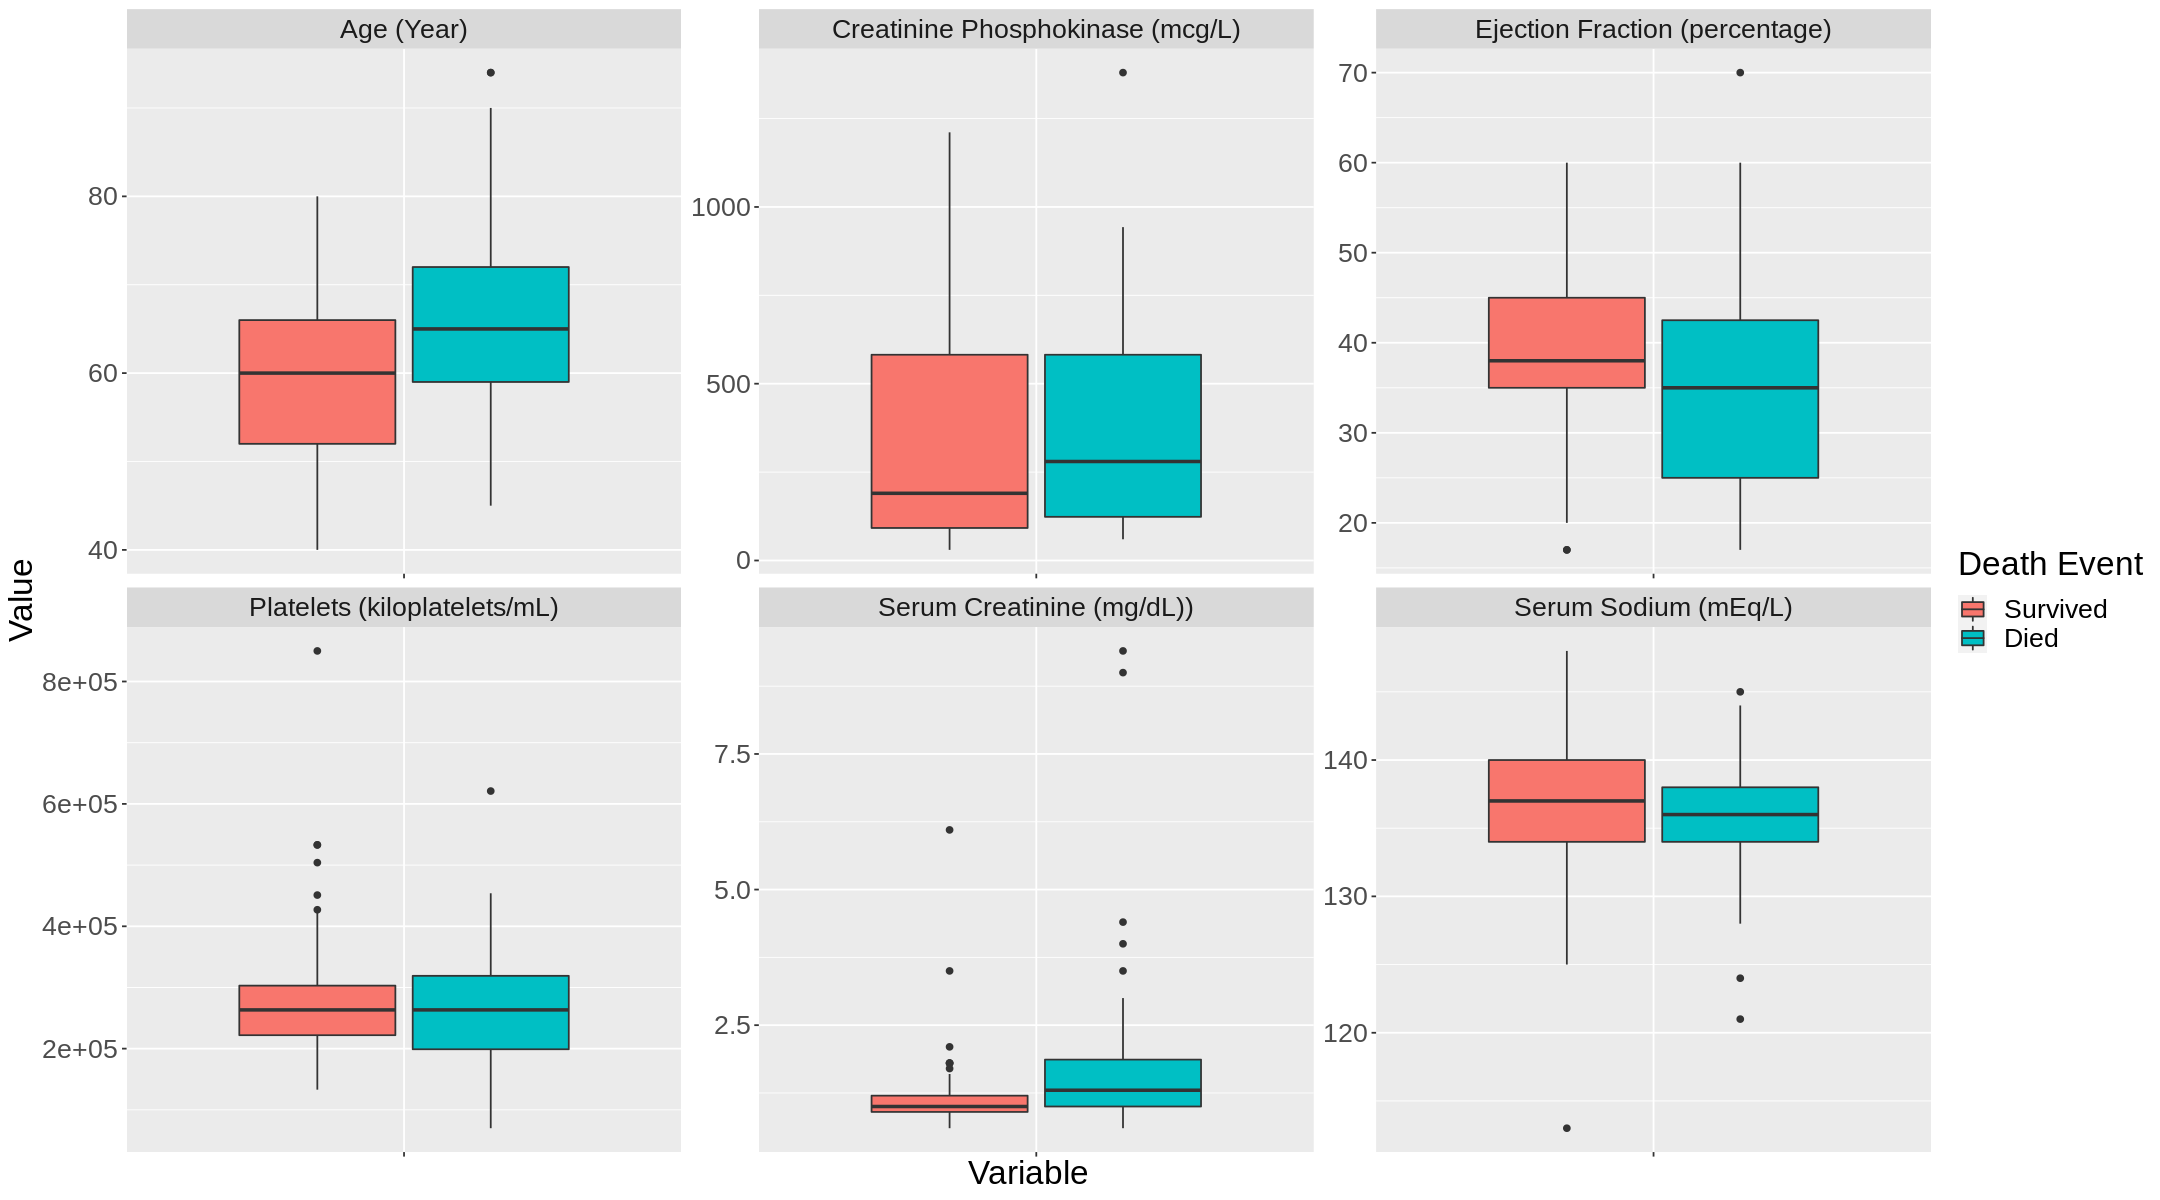

In [18]:
options(repr.plot.width = 18, repr.plot.height = 10)   # resize the shape

# source:
# https://stackoverflow.com/questions/3472980/how-to-change-facet-labels
variable_names <- c(
                    age = "Age (Year)",
                    creatinine_phosphokinase = "Creatinine Phosphokinase (mcg/L)",
                    ejection_fraction = "Ejection Fraction (percentage)",
                    platelets = "Platelets (kiloplatelets/mL)",
                    serum_creatinine = "Serum Creatinine (mg/dL))",
                    serum_sodium = "Serum Sodium (mEq/L)"
                    )

pivoted_heart_data <- heart_data_train %>% 
                    pivot_longer(cols=c(age:serum_sodium), names_to="variable", values_to="value") 

# source: 
# https://stackoverflow.com/questions/14604439/plot-multiple-boxplot-in-one-graph
heart_data_boxplot <- pivoted_heart_data %>% # all variables are merged in two columns one for the names and the other for values
                    ggplot(aes(x=variable, y=value)) +
                    geom_boxplot(aes(fill=death_event)) + 
                    facet_wrap( ~ variable, scales="free", labeller = as_labeller(variable_names))+    # boxplot them based on death_event
                    labs(x = "Variable", y = "Value") +
                    scale_fill_discrete(name = "Death Event", labels = c("Survived", "Died")) +         # legned name and values name
                    theme(text = element_text(size=20), axis.text.x = element_blank())                 # text size

# source:
# https://stackoverflow.com/questions/3261597/can-i-change-the-position-of-the-strip-label-in-ggplot-from-the-top-to-the-botto
# facet_wrap( ~ variable, scales="free", labeller = as_labeller(variable_names), strip.position="bottom") in case we want to change
#the position of the facet labels


heart_data_boxplot
options(repr.plot.width = NULL, repr.plot.height = NULL) 

From the figure above we can notice that the survive - death boxplots are very similar for *creatinine_phosphokinase* and *platelets*. Therefore, we will exclude these two variables from our predictors as the plots indicate that they will not help with our analysis.

All of the code below is used for the summarize category. It shows us a barplot of the total number of deaths to survivors, as well as a summarized table of the min, max, and mean. Additionally, it shows us if the predictors contain any NA values in their columns.

`summarise()` ungrouping output (override with `.groups` argument)



variable,min,max,mean,anyNA
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
age,40.0,94.0,61.677087,FALSE
ejection_fraction,17.0,70.0,38.531250,FALSE
serum_creatinine,0.6,9.4,1.380562,FALSE
serum_sodium,113.0,148.0,136.193750,FALSE


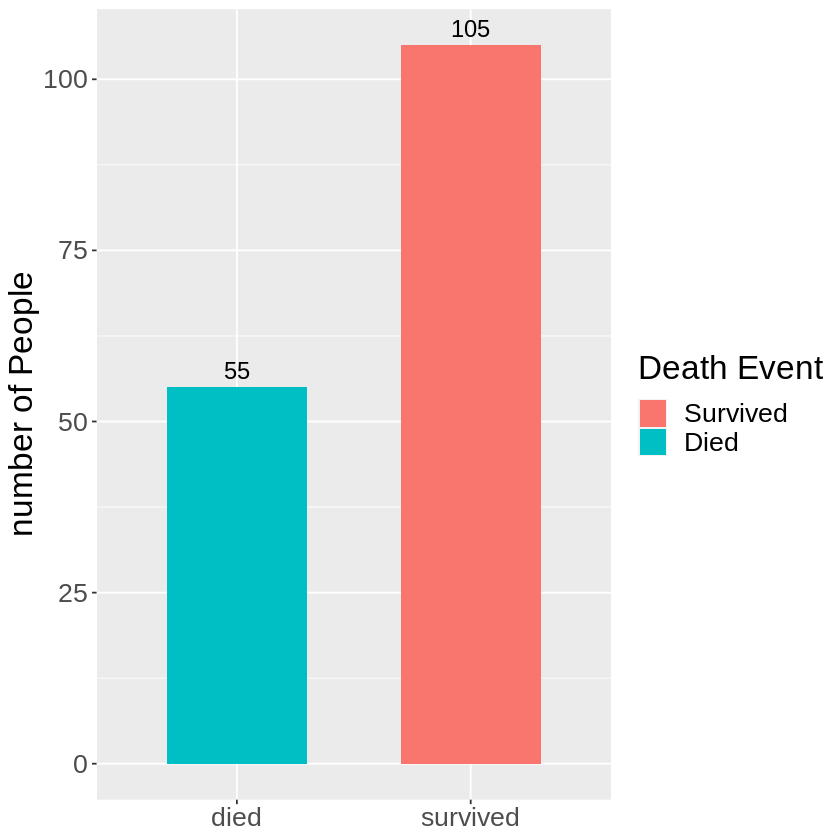

In [19]:
# Here is the summary of the dataframe:

summarized_heart_data <- pivoted_heart_data %>%
                        group_by(variable) %>%
                        summarize(min = min(value), max = max(value), mean = mean(value))  %>% 
                        mutate(anyNA = anyNA(variable)) %>%
                        filter(variable != "creatinine_phosphokinase", variable != "platelets")

death_event_column <- heart_data_train %>% select(death_event)
number_of_people <- c(death_event_column %>% 
                      filter(death_event == 0) %>% 
                      nrow(), death_event_column %>% 
                      filter(death_event == 1) %>% 
                      nrow())

death_event <- c("survived", "died")
df <- data.frame(death_event, number_of_people) 


death_event_summary_plot <- ggplot(df, aes(x=death_event, y=number_of_people, fill = death_event)) +
                            geom_bar(stat="identity", width = 0.6) +
                            labs(x = NULL, y = "number of People")  +
                            scale_fill_manual(values = c("#00bfc4", "#f8766d"), name = "Death Event", labels = c("Died", "Survived")) +
                            theme(text = element_text(size = 20)) +
                            geom_text(aes(label=number_of_people), vjust=-0.5, size=5) +
                            guides(fill = guide_legend(reverse = TRUE))
       
summarized_heart_data
death_event_summary_plot

This code below is done in preparation for the next phase of the project. The dataset is pre-processed for the future use in modelling.

In [20]:
heart_data_clean <- heart_data_train %>%
                    select(-creatinine_phosphokinase, -platelets)
heart_data_recipe <- recipe(death_event ~ ., data = heart_data_clean) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors()) %>%
            prep()

scaled_heart_data <- bake(heart_data_recipe, heart_data_train)
head(scaled_heart_data)

age,ejection_fraction,serum_creatinine,serum_sodium,death_event
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.1519780,1.86569060,-0.2495558,-1.1109707,1
1.6604256,-0.30687487,7.1331603,-0.6831601,1
1.2073247,-0.04616702,2.3299474,-1.1109707,1
-1.1487999,-0.74138797,-0.3385042,0.3863665,0
0.7542238,-1.17590106,-0.3385042,0.8141771,1
-1.2394201,1.43117750,0.4620313,-3.2500237,1


The scaled_heart_data is what we will use as the training set for our knn model.

---

## Methods

**Analysis Method:** We will conduct our data analysis with the columns which have been filtered above.

**Visualization:** FILL IN

---

## Expected outcomes and significance

**Expected Findings:** We expect to find that a higher age and serum creatinine, as well as a lower ejection fraction and serum sodium, will lead to higher risk of death by heart failure. Our model will ideally be able to determine the risk of such a death when given testing data.

**Impact of Findings:** We are analyzing this dataset for the potential benefit of the healthcare industry. If we can train our model to determine the risk of someone dying from heart failure, we can provide early warnings to people who are most at risk. This warning system could potentially save many lives, as the chance of survival drastically decreases when medical issues are left undetected.

**Future Questions:** In the future, we can potentially use the data to train a bot that regular people could use to get a better understanding of their own standing in regards to heart failure vulnerability. Additionally, this model could then be used in conjunction with other models for various health issues. This would lead to questions involving the additional effects of heart failure, rather than just determining the risk of death.